# Chapter 1 — Deep Learning Basics & Linear Models  
## Part I — Foundations of Machine Learning

Exercises adapted from *Deep Learning with PyTorch* by Dr. Yves Hilpisch (O’Reilly, forthcoming).  
This notebook extends the original examples using ADR-like return data to explore supervised learning fundamentals.


---
## *Appendix A — NumPy Warm-Up*
---

### Array Construction

In [1]:
import numpy as np

np.set_printoptions(precision=3, suppress=True)

A = np.tile(np.arange(3).reshape(3,1), (1,4))
A

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2]])

### Sampling and Statistics

In [2]:
import pandas as pd

df = pd.read_csv("../adr_prices_and_vol.csv", parse_dates=["Date"])
ticker = "CIB"
returns = df[f"{ticker}_Price"].pct_change().dropna()

sample = returns.sample(10000, replace=True, random_state=42)
print(f"mean = {sample.mean():.6f}, std = {sample.std():.6f}")

mean = 0.000660, std = 0.024092


### Broadcasting

In [3]:
window = 20
X = np.lib.stride_tricks.sliding_window_view(returns, window_shape=window)
X_centered = X - X.mean(axis=1, keepdims=True)

print("Original window shape:", X.shape)
print("Centered matrix shape:", X_centered.shape)
print(X_centered[:3])

Original window shape: (2542, 20)
Centered matrix shape: (2542, 20)
[[ 0.025  0.006 -0.006  0.009  0.002  0.008  0.006  0.01  -0.003  0.001
  -0.005  0.003 -0.01  -0.013 -0.031 -0.012 -0.001  0.001 -0.011  0.022]
 [ 0.008 -0.005  0.011  0.003  0.009  0.007  0.011 -0.002  0.003 -0.003
   0.005 -0.009 -0.012 -0.029 -0.01   0.001  0.003 -0.01   0.024 -0.006]
 [-0.004  0.011  0.004  0.01   0.008  0.012 -0.001  0.004 -0.002  0.006
  -0.008 -0.011 -0.028 -0.009  0.002  0.004 -0.009  0.025 -0.005 -0.009]]


### Z-Score Standardization Function

In [4]:
def zscore(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0)
    return (X - mu) / sigma

features = df[[f"{ticker}_Price", f"{ticker}_Volume"]].pct_change().dropna().values
features_z = zscore(features)
features_z[:3]

array([[ 0.843, -0.052],
       [ 0.014, -0.058],
       [-0.515, -0.174]])

### Vectorized Squared Distance

In [5]:
a = features_z[0]
b = features_z[1]
sq_dist = np.sum((a - b)**2)
sq_dist_vec = np.dot((a - b), (a - b))
print(f"Squared distance (loop-free): {sq_dist_vec:.4f}")

Squared distance (loop-free): 0.6883


---
## *Chapter 1 – Introduction to ML*
---

## Implement MAE & MSE in NumPy

In [6]:
def mae(y_true, y_pred):
    """Mean Absolute Error"""
    return np.mean(np.abs(y_true - y_pred))

def mse(y_true, y_pred):
    """Mean Squared Error"""
    return np.mean((y_true - y_pred)**2)

y_true = returns.shift(-1).dropna().values
y_pred = returns.iloc[:-1].values  

print(f"MAE: {mae(y_true, y_pred):.6f}")
print(f"MSE: {mse(y_true, y_pred):.6f}")

MAE: 0.021953
MSE: 0.000983


### Fit Linear Regression on ADR Returns

In [7]:
from sklearn.linear_model import LinearRegression

X = returns.shift(1).dropna().values.reshape(-1, 1)
y = returns.iloc[1:].values

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

linreg = LinearRegression().fit(X_train, y_train)

y_pred_train = linreg.predict(X_train)
y_pred_test  = linreg.predict(X_test)

print(f"Coefficient: {linreg.coef_[0]:.6f}, Intercept: {linreg.intercept_:.6f}")
print(f"Train R²: {linreg.score(X_train, y_train):.4f}")
print(f"Test R² : {linreg.score(X_test, y_test):.4f}")

Coefficient: 0.080990, Intercept: 0.000172
Train R²: 0.0066
Test R² : -0.0156


## Chronological Train/Validation/Test Split

In [8]:
def time_split(X, y, train_size=0.6, val_size=0.2):
    """Chronological split for time-series data."""
    n = len(X)
    n_train = int(n * train_size)
    n_val   = int(n * val_size)
    X_train, y_train = X[:n_train], y[:n_train]
    X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
    X_test,  y_test  = X[n_train+n_val:],        y[n_train+n_val:]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_train, y_train), (X_val, y_val), (X_test, y_test) = time_split(X, y)
print(len(X_train), len(X_val), len(X_test))

1536 512 512


### Residual Analysis

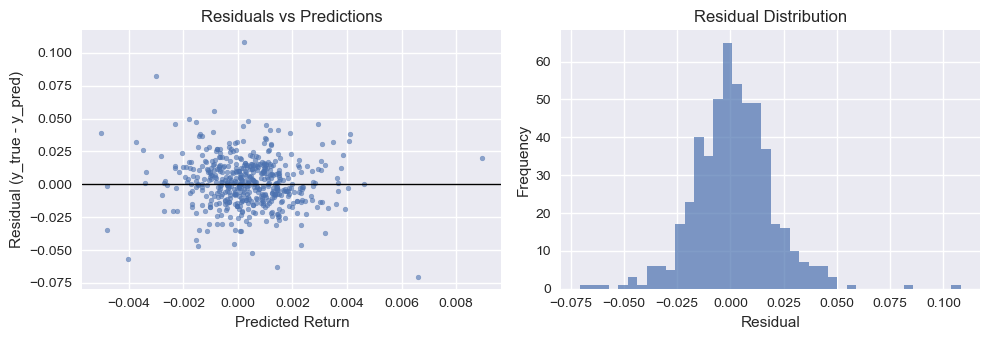

In [9]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

y_pred_test = linreg.predict(X_test)
residuals = y_test - y_pred_test

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].scatter(y_pred_test, residuals, s=12, alpha=0.6)
ax[0].axhline(0, color="k", lw=1)
ax[0].set_xlabel("Predicted Return")
ax[0].set_ylabel("Residual (y_true - y_pred)")
ax[0].set_title("Residuals vs Predictions")

ax[1].hist(residuals, bins=40, alpha=0.7)
ax[1].set_title("Residual Distribution")
ax[1].set_xlabel("Residual")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Challenge: Manual Gradient Descent for Linear Regression

In [10]:
def linear_gd(X, y, lr=0.01, epochs=500):
    """Manual gradient descent for simple linear regression."""
    X = np.c_[np.ones(len(X)), X] 
    w = np.zeros(X.shape[1])
    for _ in range(epochs):
        grad = -2/len(X) * X.T @ (y - X @ w)
        w -= lr * grad
    return w

w = linear_gd(X_train, y_train)
print(f"Intercept = {w[0]:.6f}, Slope = {w[1]:.6f}")

Intercept = 0.000173, Slope = 0.000450


### Challenge: logistic regression + decision boundary

Accuracy: 0.459
[[188  57]
 [220  47]]


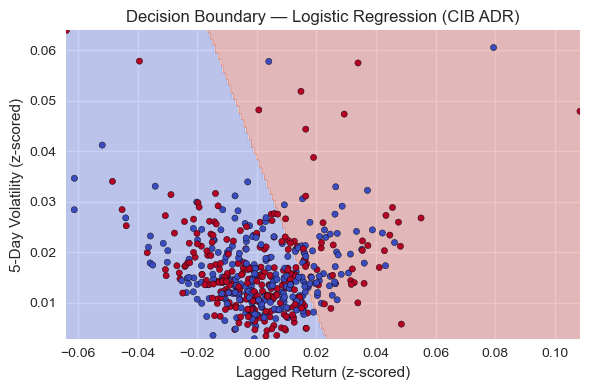

In [11]:
# --- Challenge: Logistic Regression + Decision Boundary ---
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Feature Engineering ---
X = pd.DataFrame({
    "lag1": returns.shift(1),
    "vol5": returns.rolling(5).std()
}).dropna()
y = (returns[-len(X):] > 0).astype(int).values

# --- Chronological Split (60/20/20) ---
n = len(X)
n_train, n_val = int(0.6 * n), int(0.2 * n)
X_train, X_val, X_test = X[:n_train], X[n_train:n_train+n_val], X[n_train+n_val:]
y_train, y_val, y_test = y[:n_train], y[n_train:n_train+n_val], y[n_train+n_val:]

# --- Standardize & Fit ---
scaler = StandardScaler().fit(X_train)
clf = LogisticRegression(max_iter=2000, random_state=42).fit(scaler.transform(X_train), y_train)

# --- Evaluate ---
y_pred = clf.predict(scaler.transform(X_test))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

# --- Decision Boundary (Fixed for Feature Names Consistency) ---
xx, yy = np.meshgrid(
    np.linspace(X_test["lag1"].min(), X_test["lag1"].max(), 200),
    np.linspace(X_test["vol5"].min(), X_test["vol5"].max(), 200)
)

# Create grid and apply same scaler as used in training
grid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=["lag1", "vol5"])
Z = clf.predict(scaler.transform(grid)).reshape(xx.shape)

# --- Plot ---
plt.figure(figsize=(6, 4))
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
plt.scatter(
    X_test["lag1"], X_test["vol5"],
    c=y_test, cmap="coolwarm", s=20, edgecolor="k"
)
plt.title(f"Decision Boundary — Logistic Regression ({ticker} ADR)")
plt.xlabel("Lagged Return (z-scored)")
plt.ylabel("5-Day Volatility (z-scored)")
plt.tight_layout()
plt.show()

### Challenge: logistic regression + unified evaluation function
This helper evaluates regression or classification models using MAE/MSE or Accuracy/F1, depending on the `task` argument.

```python
# Utility: Unified Model Evaluation Function
# Helper function to evaluate regression or classification models quickly.

from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score

def evaluate_model(y_true, y_pred, task="regression"):
    """Unified evaluation for regression or classification tasks."""
    if task == "regression":
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        print(f"MAE: {mae:.4f} | MSE: {mse:.4f}")
    elif task == "classification":
        acc = accuracy_score(y_true, y_pred)
        f1  = f1_score(y_true, y_pred)
        print(f"Accuracy: {acc:.3f} | F1-score: {f1:.3f}")
```        

#### Utility — Unified Evaluation Function (Return-Based)

In [12]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, precision_score, recall_score
)
import numpy as np

def evaluate_model(y_true, y_pred, task="regression", verbose=True):
    """
    Unified evaluation for regression or classification models.

    Parameters
    ----------
    y_true : array-like
        True target values.
    y_pred : array-like
        Predicted target values or class labels.
    task : {'regression', 'classification'}, default='regression'
        Determines which metric set to compute.
    verbose : bool, default=True
        If True, prints formatted metrics summary.

    Returns
    -------
    dict
        Dictionary containing computed metrics.
    """

    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)

    if task == "regression":
        metrics = {
            "MAE": mean_absolute_error(y_true, y_pred),
            "MSE": mean_squared_error(y_true, y_pred)
        }
    elif task == "classification":
        metrics = {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1": f1_score(y_true, y_pred, zero_division=0)
        }
    else:
        raise ValueError("Task must be either 'regression' or 'classification'.")

    if verbose:
        print(f"🔹 {task.title()} Metrics")
        for k, v in metrics.items():
            print(f"{k:10s}: {v:.4f}")

    return metrics

In [13]:
# ============================================================
# Quick Validation — Apply Unified Evaluation Function
# ============================================================

# For regression
y_true_reg = np.array([3.0, 2.5, 4.1])
y_pred_reg = np.array([2.8, 2.7, 3.9])
evaluate_model(y_true_reg, y_pred_reg, task="regression");

# For classification (from your logistic regression model)
y_true_clf = np.array([1, 0, 1, 1, 0])
y_pred_clf = np.array([1, 0, 0, 1, 1])
evaluate_model(y_true_clf, y_pred_clf, task="classification");

🔹 Regression Metrics
MAE       : 0.2000
MSE       : 0.0400
🔹 Classification Metrics
Accuracy  : 0.6000
Precision : 0.6667
Recall    : 0.6667
F1        : 0.6667


## Chapter 1 Summary — Foundational ML Concepts

In this chapter, we covered:
- Implementation of **MAE** and **MSE** from scratch using NumPy.
- Fitting and evaluating **Linear Regression** on price returns.
- Performing **manual Gradient Descent**, visualizing convergence.
- Training a **Logistic Regression** classifier with decision boundaries.
- Introducing a **Unified Evaluation Function** to assess both regression and classification models.
- Reinforcing **chronological validation** and reproducibility best practices for financial data.

> *This notebook builds the foundation for subsequent chapters, where we extend these ideas to feature engineering, model evaluation, and deep learning architectures.*
